<ipython-input-4-be2c1702239a>:12: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("/content/preprocessed_train_data (1).csv")
<ipython-input-4-be2c1702239a>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[target_col].fillna(train_df[target_col].mode()[0], inplace=True)


k = 1 → Accuracy = 0.9499
k = 2 → Accuracy = 0.9463
k = 3 → Accuracy = 0.9497
k = 4 → Accuracy = 0.9470
k = 5 → Accuracy = 0.9491
k = 6 → Accuracy = 0.9471
k = 7 → Accuracy = 0.9481
k = 8 → Accuracy = 0.9469
k = 9 → Accuracy = 0.9477
k = 10 → Accuracy = 0.9468


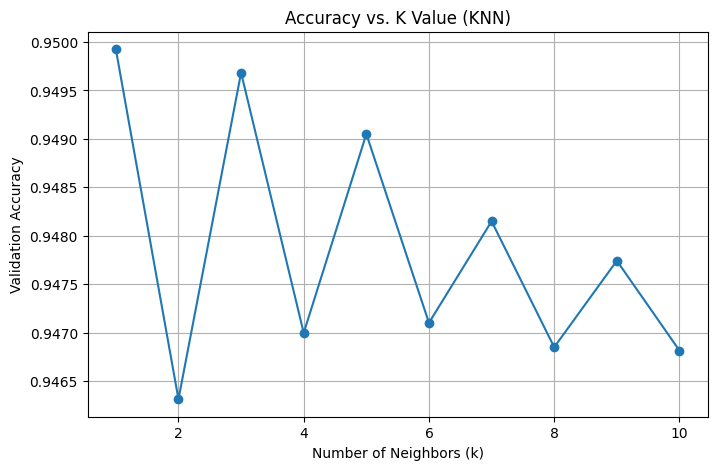


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     37861
           2       1.00      1.00      1.00     30912
           3       0.51      0.50      0.50      5584
           4       1.00      1.00      1.00     34430
           5       0.59      0.60      0.59      6660

    accuracy                           0.95    115447
   macro avg       0.82      0.82      0.82    115447
weighted avg       0.95      0.95      0.95    115447



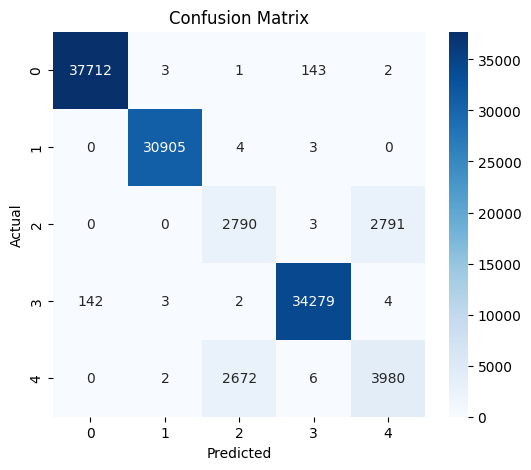


✅ Predictions saved to 'test_predictions.csv'


In [4]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 2: Load Preprocessed Datasets
train_df = pd.read_csv("/content/preprocessed_train_data (1).csv")
test_df = pd.read_csv("/content/preprocessed_test_data (1).csv")

# Step 3: Encode 'outlet_city'
combined_cities = pd.concat([train_df["outlet_city"], test_df["outlet_city"]], axis=0).astype(str)
city_encoder = LabelEncoder()
city_encoder.fit(combined_cities)

train_df["outlet_city"] = city_encoder.transform(train_df["outlet_city"].astype(str))
test_df["outlet_city"] = city_encoder.transform(test_df["outlet_city"].astype(str))

# Step 4: Clean and Validate Target Column
target_col = "cluster_catgeory"
train_df[target_col].fillna(train_df[target_col].mode()[0], inplace=True)
train_df[target_col] = train_df[target_col].astype(str).str.extract("(\d+)")[0]
train_df = train_df[train_df[target_col].notna()]
train_df[target_col] = train_df[target_col].astype(int)

# Step 5: Ensure only valid clusters (0 to 5)
valid_clusters = [0, 1, 2, 3, 4, 5]
train_df = train_df[train_df[target_col].isin(valid_clusters)]

# Step 6: Define Features and Target
X = train_df.drop(columns=["Customer_ID", target_col])
y = train_df[target_col]

# Step 7: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Find Optimal K
accuracy_list = []
k_range = range(1, 11)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_val)
    acc = accuracy_score(y_val, y_pred_k)
    accuracy_list.append(acc)
    print(f"k = {k} → Accuracy = {acc:.4f}")

# Step 9: Plot Accuracy vs K
plt.figure(figsize=(8, 5))
plt.plot(k_range, accuracy_list, marker='o')
plt.title("Accuracy vs. K Value (KNN)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

# Step 10: Train Final Model with Best K
best_k = accuracy_list.index(max(accuracy_list)) + 1
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

# Step 11: Evaluate on Validation Set
y_val_pred = knn_model.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 13: Predict on Test Data
X_test = test_df.drop(columns=["Customer_ID"])
test_predictions = knn_model.predict(X_test)
test_df["Predicted_cluster"] = test_predictions

# Step 14: Save Predictions to CSV
output_df = test_df[["Customer_ID", "Predicted_cluster"]]
output_df.to_csv("test_predictions.csv", index=False)

print("\n✅ Predictions saved to 'test_predictions.csv'")
